In [1]:
import numpy as np
import math as m
import Functions as f
import Plotting as p
import Constants as c

# Introduction # 

This project involves the replication of Stommel's model for a western boundary current in a closed ocean basin (Stommel, 1948). The western boundary current is a poleward flow of near-surface water in an ocean gyre along the western edge of the basin. To replicate Stommel's model we will consider a square ocean basin with 1000km long sides ($L$) and of a uniform 1km depth ($H$). The model is driven by a zonal wind stress, without which the flows would not change. There is, at this point, no meridional wind stress applied to the model.

The model is described by a set of shallow water equations which include the aforementioned wind stress:

$$\frac{\partial \eta}{\partial t} + H \nabla \cdot{V} = 0$$
$$\frac{\partial V}{\partial t} + (f_0 + \beta y)k \times V = -g \nabla \eta - \gamma V + \frac{\tau}{\rho H}$$
$$ \tau_x = \tau_0 \left( -cos(\frac{\pi y}{L}) \right) $$

where the coriolis parameter $f_{0} = 10^{-1} s^{-1}$, the beta plane constant (Rossby parameter) $\beta = 10^{-11} m^{-1} s^{-1}$, acceleration due to gravity $g = 10 ms^{-1}$, the linear drag coefficient $\gamma = 10^{-6} s^{-1}$, and the density of the water $\rho = 1000 kg m^{-3}$.


# Task A #

The Stommel model supports waves with longer wavelengths than short gravity waves, which have a wavelength on the order of $10^{5}m$. Short gravity waves travel at speeds on the order of $100ms^{-1}$, with lamb waves, the fastest inertial gravity waves, travelling at $\sim300ms^{-1}$ (although we are not concerned with lamb waves in this model). Their short wavelength and fast propagation speed makes short gravity waves the most important for calculating the CFL criterion:

$$C \leq \frac{u \Delta t}{\Delta x}$$

where $C = \frac{1}{\sqrt{2}}$ in 2 dimensions. This means that short gravity waves have the most significant limiting impact on the timestep length that it is possible to use in the model.

Short gravity waves will not be spawned by the initial conditions of the model because it is initiated from rest. Gravity waves would require an initial perturbation of the surface elevation to be spawned by the initial conditions, meaning any that arise in the model will be the result of the integration method used. By running the model until a steady state we should reach a point where the surface elevation no longer changes between timesteps, so we should eliminate the propagation of short gravity waves if the model reaches a steady state.

The Rossby radius of deformation is given as 

$$R_{d} = \frac{\sqrt{gH}}{f_0}$$

where g is vertical acceleration due to gravity (assumed to be $10ms^{-1}$), H is the depth of the ocean basin being considered ($1000m$), and $f_0$ is the coriolis parameter ($10^{-4}s^{-1}$). This give $R_{d} = 10^{6}m$.

To choose an appropriate grid length you must consider the largest grid spaces which could resolve the short gravity waves. Four gridspaces are required to properly resolve a wave, so this gives $d = 2.5$x$10^{4}m$, however this has been adjusted down in this model implementation to $d = 2$x$10^{4}m$ to provide more gridspaces and a higher resolution result. The motivation for this was to properly resolve the western boundary current, as it is expected to feature a sharp gradient in $\eta$ and $v$.

This grid spacing gives $\frac{R_{d}}{d} = 50$, corresponding with a very fine grid, for which it would be suitable to use an Arakawa C grid because it is one of the least damaging Arakawa grids for fine resolutions. An example diagram of a 5x5 gridspace Arakawa C grid is shown below, and is important for visualising the implementation of indexing in the model.

(If this image does not properly render, it is found in the assignment folder as Arakawa_Grid.png)

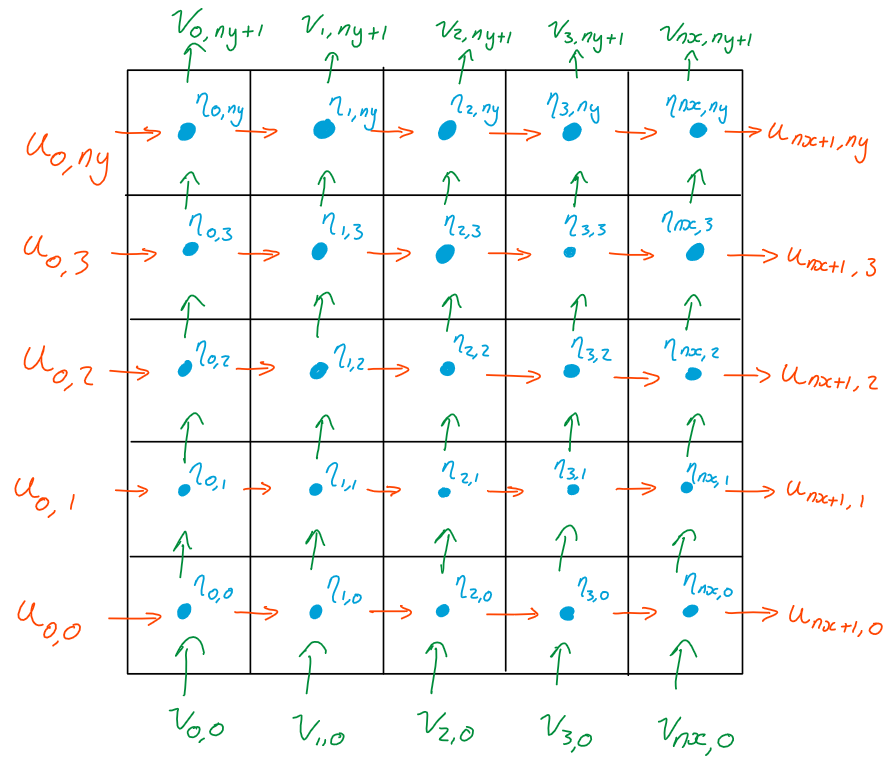

Using the equation for the CFL criterion we can calculate the longest conditionally stable timestep, which is found to be $\sim 141.4s$. This is given the assumption that the fastest short gravity waves we will encounter will be $100ms^{-1}$, however it was found that there are faster gravity waves propagating in the model so the timestep had to be adjusted to become shorter to account for this and keep stability. We will be using a timestep of $\Delta t = 120s$ unless otherwise stated, because this keeps the model conditionally stable for a larger numbers of timesteps under the observation that $100ms^{-1}$ is not the fastest gravity wave in the model. Using a timestep of $120s$ allows for gravity waves of speeds up to $118ms^{-1}$.



# Task B #

As we are beginning the model from rest, the initial conditions of our model are that, for the entire grid, $u = 0ms^{-1}$, $v = 0ms^{-1}$, and $\eta = 0m$.

The boundary conditions being used concern the speed of the water, as there cannot be water flowing directly into or out of the boundaries. Therefore, u(0, x), u(nx, x), v(y, 0), and v(y, ny) (The boundaries of the ocean basin) are kept at zero in the model. 

For $\eta$ there are no strict boundary conditions.

A flowchart planning the development of the model is produced as such:

1. Set timesteps 
  - $nt = \frac{d}{dt}$
2. Create grids 
  - $\eta$ (50x50), $u$ (50x51), $v$ (51x50)
  - Coriolis grid (50x50)
3. Set boundary conditions
  - $u$ (0, x) = 0,  $u$ (nx, x) = 0
  - $v$ (y, 0) = 0, $v$ (y, ny) = 0
4. Define constants
5. Define integration equations
  - Alternate u and v equations
6. Additional functions
  - Interpolation
  - Derivatives
  - Wind shear
7. Create plots


# Task C #

The analytical solution of the ocean gyre problem. It produces a western boundary current with a fast moving northward flow along the western boundary and a positive surface height anomaly displaced slightly to the west. 

This solution initially uses $\eta_{0} = 0$, then repeats using $\eta_{0} = \eta (0, L/2)$ from the previous analytical solution. This provides a more accurate approximation of the real western boundary current.

This is the expected result of the analytical model and it matches the patterns shown by Stommel (Stommel, 1948). 


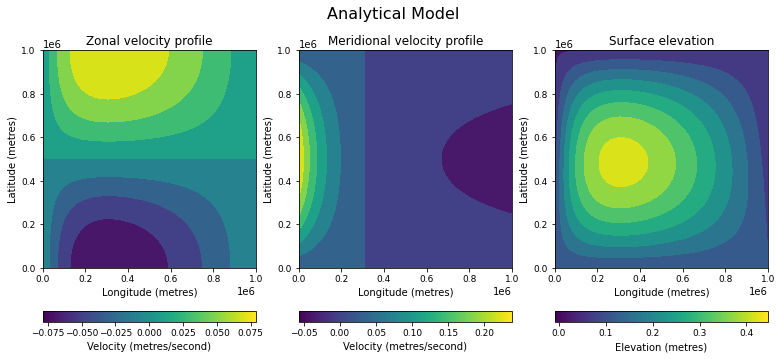

In [2]:
# Running the analytical model
p.analytic_plot(c.param_analytic)


# Task D #

To solve the problem numerically we use the forward-backward time scheme defined by Matsuno (1966), with the following equations.

$$\eta^{n+1} = \eta^{n} - H\Delta t \left( \frac{\partial{u^{n}}}{\partial{x}} + \frac{\partial{v^{n}}}{\partial{y}}\right)$$

$$u^{n+1} = u^{n} + (f_{0} + \beta y)\Delta t v^{n} - g \Delta t \frac{\partial \eta^{n+1}}{\partial x} - \gamma \Delta t u^{n} + \frac{\tau_{x}}{\rho H}\Delta t$$

$$v^{n+1} = v^{n} - (f_{0} + \beta y)\Delta t u^{n} - g \Delta t \frac{\partial \eta^{n+1}}{\partial y} - \gamma \Delta t v^{n} + \frac{\tau_{y}}{\rho H}\Delta t$$

where, for alternating timesteps, the order of operation of u and v are switched. 

Running initially for just one day we observe a slight positive elevation perturbation of the water towards the centre of the basin, with zonal and meridional speeds at their largest in the centre of the basin. 

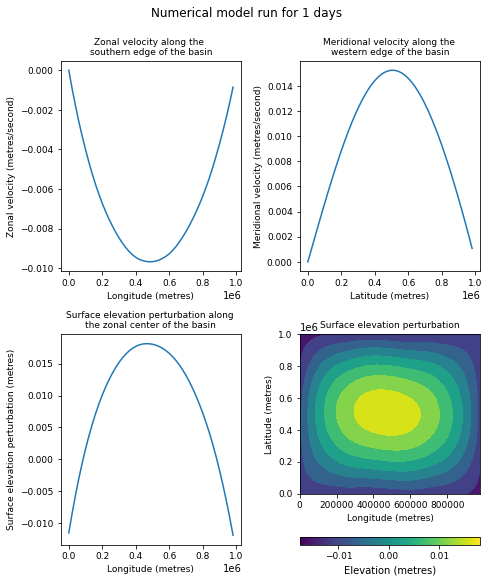

In [3]:
# Running the numerical model for 1 day
p.task_d1_plot(c.param_1day)


Continuing to 50 days, we observe that the positive surface elevation perturbation intensifies and moves westward. The zonal and meridional flows also intesify, particularly the meridional flow which increases significantly flowing north along the western boundary. At this point we have reached a steady state, which will be shown by the energy method in task E. 

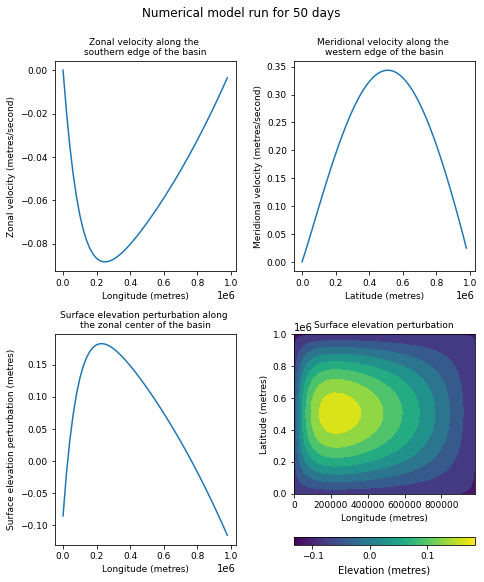

In [4]:
# Running the numerical model for 50 days
p.task_d1_plot(c.param_50day)


It is useful to see the difference between the analytical and numerical models. We see that the analytical model features a higher central elevation perturbation, while the numerical model has a faster northward flow across the western boundary. There is also significant difference in the magnitudes of elevation and speed observed between the two models, which could be further investigated.

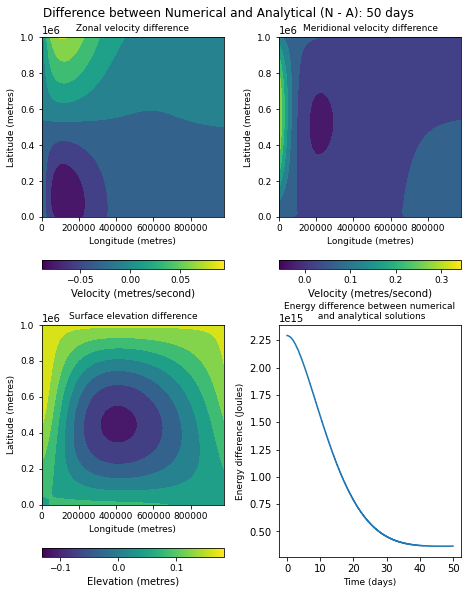

In [5]:
# Plotting the difference between the numerical and 
# analytical models over 50 days
p.diff_plot(c.param_50day)

# Task E # 

The energy method involves computing the difference in total energy between the numerical and analytical models, where the total energy is given by 

$$ E(u, v, \eta) = \int^L_0 \int^L_0 \frac{1}{2} \rho (H(u^2+v^2) + g \eta^2) dxdy $$.

By comparison of the energy difference between the analytical and numerical models we can determine when the numerical model has reached a steady state. For this particular configuration of the problem the energy difference between the models is minimised at around 45 days. As such, it seems sensible to run the model for 50 days. 

Final energy difference (N - A) = 3.660744e+14 Joules


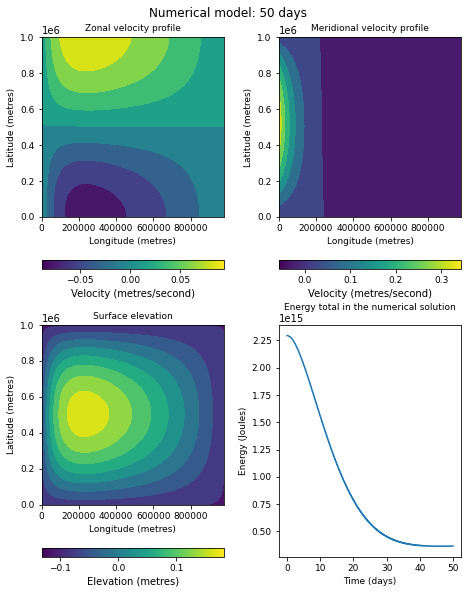

In [6]:
# Running the numerical model for 50 days
p.numerical_plot(c.param_50day)

To reduce the size of the grid spacings we need to recompute the CFL criterion for the model. Simply, to reduce the grid sizes by a half we need to decrease the timestep durations by a half. Here we have decreased from $\Delta t = 120s$ to $\Delta t = 60s$. It was discovered however that this did not preserve stability in the model up to 50 days, so the timestep has been reduced to $\Delta t = 58s$. This demonstrates that there are fast moving inertial gravity waves in the model which are only just being accounted for with the CFL criterion. By reducing the size of the grid spacing by half to $d = 1000m$ we can see that the energy difference between the numerical and analytical solutions at steady state becomes smaller, however not much smaller. This energy difference decreases from $\sim 3.66$x$10^{14} J$ to $\sim 3.33$x$10^{14} J$, which is not a significant amount considering doubling the resolution of the model requires eight times as many calculations to be performed. 

Final energy difference (N - A) = 3.332928e+14 Joules


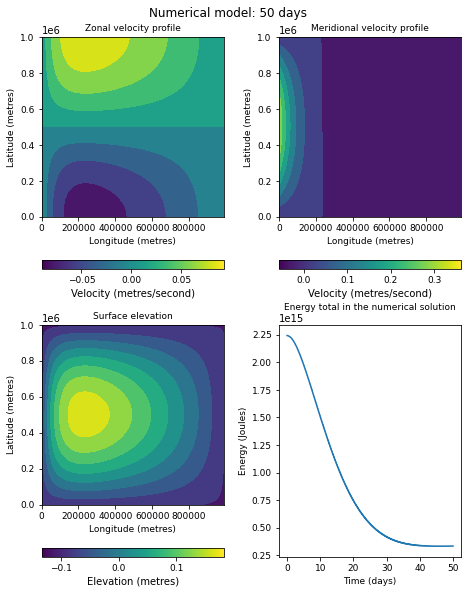

In [7]:
# Running the numerical model for 50 days with gridsize halved
p.numerical_plot(c.param_50day_halfgrid)

# Task G5 #

During an ENSO warm phase there are sea surface height perturbations in the Atlantic, with an increase in the east and a decrease in the west of up to around 30cm (Zheng, 2015). This will be crudely replicated by changing the initial conditions of the numerical model. Making $\eta$ zonally sinusoidal with an amplitude of 30cm, we can construct a vaguely similar situation to what may be seen in an ENSO warm phase in the Atlantic. No other parameters, such as the depth of size of the basin, are being changed to replicate the Atlantic ocean, and as such this should not be considered in any way an accurate model of the dynamics of the Atlantic. This is moreso a jumping off point for discussing how initial conditions affect the model.

Here we see that for short lengths of time, such as just a day, the model partly resembles the sinusoidal pattern that it was initiated with, and the model takes slightly longer to reach a steady state. However, because there is no stochastic forcing, because these are only the initial conditions which have been changed, this model eventually reaches the same steady state regardless of its initial conditions.

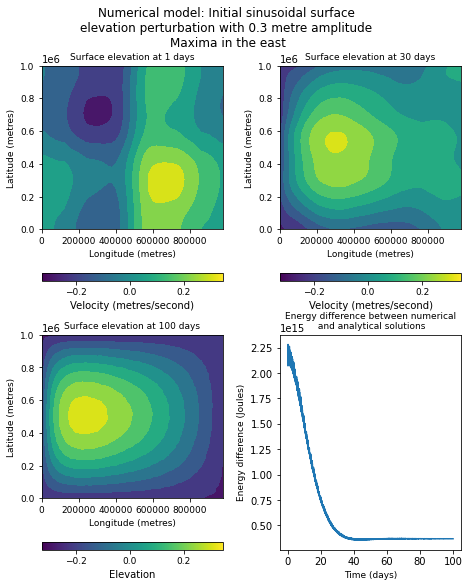

In [8]:
# Running the numerical model for 1, 30, and 100 days, with an initial 
# sinusoidal elevation perturbation of amplitude 30cm
p.varying_IC_plot(c.param_1day_sin03, c.param_30day_sin03, c.param_100day_sin03)

By setting the amplitude of the initial surface perturbation to be larger, to 1m, we see that it now takes slightly longer for the model to reach a steady state, demonstrating that the amplitude of the perturbation does have an effect on the development of the model. Again, the model eventually reaches a steady state which looks the same as that which is observed when there is no change to the initial conditions. Interestingly, because the model is initiated with an initial negative surface elevation in the east, where we have a maxima in the analytic model, the energy difference between the models is negative at points very early on in the model's initialisation. 

As an aside, it can be seen that this model is tending towards instability, as the contours of the elevation plot become warped at 100 days. This means that, to keep stability, it would be necessary to decrease our timestep slightly because there must be inertial gravity waves propagating slightly faster than was factored into the calculation of the CFL criterion, which was used to find an appropriate timestep of $120s$. 

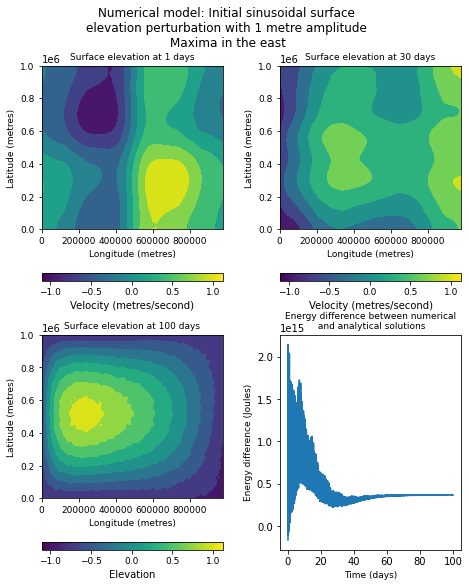

In [12]:
# Running the numerical model for 1, 30, and 100 days, with an initial 
# sinusoidal elevation perturbation of amplitude 1m
p.varying_IC_plot(c.param_1day_sin1, c.param_30day_sin1, c.param_100day_sin1)

We can introduce stochastic forcing to the model through the additional of a meridional wind shear term to match the zonal wind stress term that we already have. Setting $\tau_{y} = 1ms^{-1}$ we observe a shift of the gyre to the north, which is to be expected from applying a northward wind stress. The model again reaches a steady state, however unlike what was observed by varying the initial conditions, this is a different steady state to what we would otherwise see, demonstrating that stochastic forcing affects the final state of the model whereas changes to the initial conditions just appear to just affect how long it takes to reach a steady state. 

Final energy difference (N - A) = 3.626460e+14 Joules


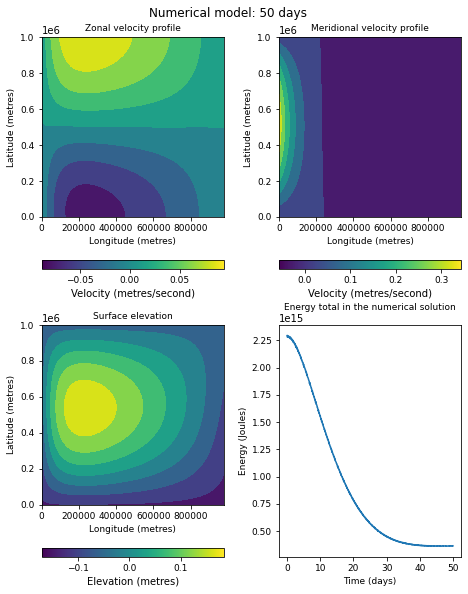

In [10]:
# Running the numerical model for 50 days with a southerly meridional wind 
# stress of 1m/s applied 
p.numerical_plot(c.param_50day_stochastic)

When combining the sinusoidal initial conditions and the meridional wind stress we see that the model again eventually reaches a steady state similar to what is observed in the model with added meridional wind stress. It must be noted that the timestep for this model has been reduced from $\Delta t = 120s$ to $\Delta t = 100s$ as it was found the model would become unstable for long periods of time but before it had reached a steady state. 

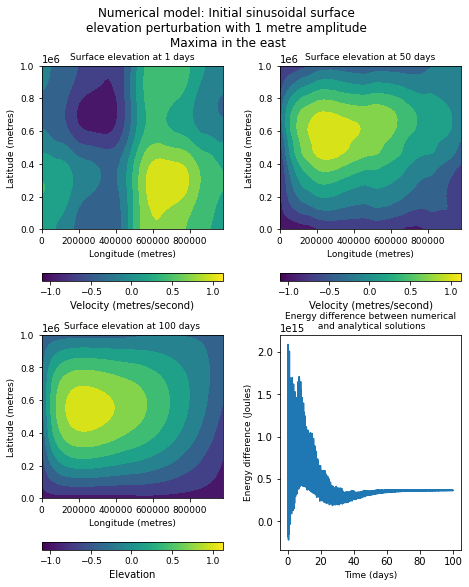

In [11]:
# Running the numerical model for 1, 30, and 100 days, with an initial 
# sinusoidal elevation perturbation of amplitude 1m and a southerly 
# meridional wind stress of 1m/s applied 
p.varying_IC_plot(c.param_1day_stochastic_sin1, c.param_50day_stochastic_sin1, c.param_100day_stochastic_sin1)

# References # 

Matsuno, T. (1966): Quasi-Geostrophic Motions in the Equatorial Area, *Journal of the Meteorological Society of Japan*, __44__(1), 25-43.

Stommel, H. (1948): The Westward Intensification of Wind-Driven Ocean Currents, *American Geophysical Union Transactions*, __29__(2), 202-206.

Zheng, Z. W. et al. (2015): A Long Neglected Damper in the El Niño - Typhoon Relationship: A 'Gaia-Like' Process, *Scientific Reports*, __5__(1): 11103.

